In [1]:
import os
import numpy as np
from PIL import Image

def process_orl_faces(directory, gender_labels):
    """
    Converts ORL face images into a 400×2576 data matrix and appends a gender label.

    Args:
        directory (str): The path to the ORL dataset.
        gender_labels (dict): Dictionary mapping person IDs (01-40) to gender labels (0=female, 1=male).

    Returns:
        np.ndarray: A (400, 2577) matrix containing flattened images with gender labels.
    """

    files = sorted([f for f in os.listdir(directory) if f.endswith(".png")])
    num_images = len(files)
    img_shape = (46, 56)  # ORL images are 46×56 (Width × Height)
    feature_size = img_shape[0] * img_shape[1]  # 46 × 56 = 2576

    data_matrix = np.zeros((num_images, feature_size + 1))  # Extra column for gender

    for idx, filename in enumerate(files):
        person_id = filename.split("_")[0]  # Extract person ID (01-40)
        gender = gender_labels.get(person_id, -1)  # Default to -1 if unknown

        img_path = os.path.join(directory, filename)
        with Image.open(img_path) as img:
            img = img.convert("L")  # Convert to grayscale (if not already)
            img_array = np.array(img).flatten()  # Flatten 46×56 → 2576

        data_matrix[idx, :-1] = img_array  # Store flattened image
        data_matrix[idx, -1] = gender  # Store gender label

    return data_matrix

gender_labels = {
    "01": 0, "02": 1, "03": 1, "04": 1, "05": 1,
    "06": 1, "07": 1, "08": 0, "09": 1, "10": 0,
    "11": 1, "12": 1, "13": 1, "14": 1, "15": 1,
    "16": 1, "17": 1, "18": 1, "19": 1, "20": 1,
    "21": 1, "22": 1, "23": 1, "24": 1, "25": 1,
    "26": 1, "27": 1, "28": 1, "29": 1, "30": 1,
    "31": 1, "32": 0, "33": 1, "34": 1, "35": 1,
    "36": 1, "37": 1, "38": 1, "39": 1, "40": 1,
}

# Define the dataset directory
directory_path = "/Users/chun-feitan/Desktop/tpe/IE5054/ORL Faces"  # Update with the actual path

# Process the images
orl_data_matrix = process_orl_faces(directory_path, gender_labels)

# Save the matrix as a NumPy file
np.save("/Users/chun-feitan/Desktop/tpe/IE5054/orl_faces_with_gender.npy", orl_data_matrix)

print("Data matrix shape:", orl_data_matrix.shape)  # Expected (400, 2577)

Data matrix shape: (400, 2577)


### ✅ Question 1
Find the proper libraries/packages to perform the LASSO and Ridge regressions on the ORL face dataset.

 - a. (10%) Identify the value of 𝜆 that yields the minimum MSE in both LASSO and Ridge regression models. Compare the results, including selected features and model performance, with those obtained from your stepwise regression in HW02.
 - b. (5%) Plot the chosen pixels from LASSO regression on a 46 × 56 canvas.

Finding optimal lambda for LASSO...


/Users/chun-feitan/Desktop/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.602e-03, tolerance: 2.111e-03
  model = cd_fast.enet_coordinate_descent(
/Users/chun-feitan/Desktop/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.728e-03, tolerance: 2.111e-03
  model = cd_fast.enet_coordinate_descent(
/Users/chun-feitan/Desktop/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

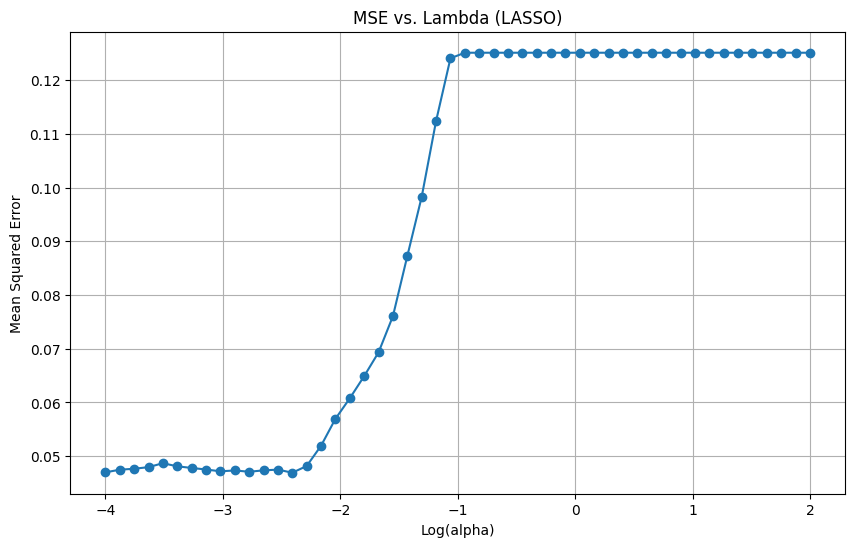

Optimal lambda for LASSO: 0.003907, Min MSE: 0.046907

Finding optimal lambda for Ridge...


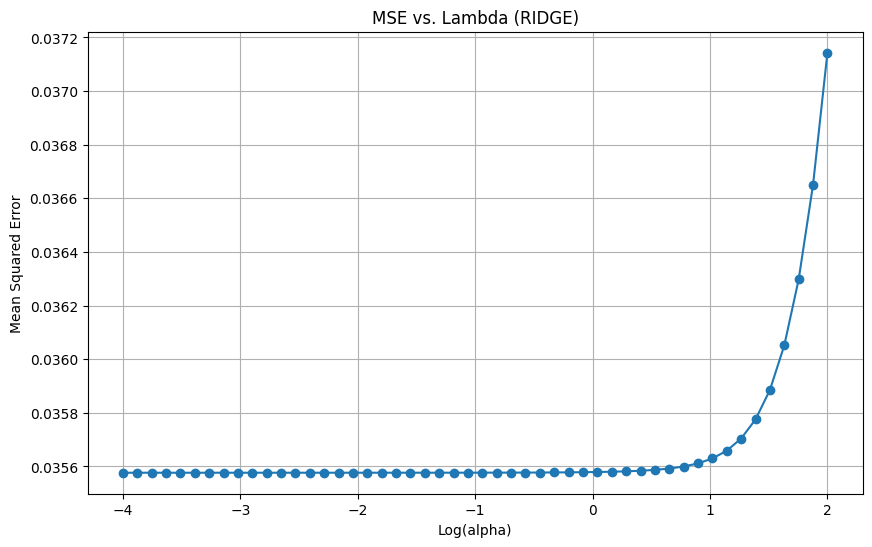

Optimal lambda for Ridge: 0.000100, Min MSE: 0.035577

Analyzing feature selection in LASSO...


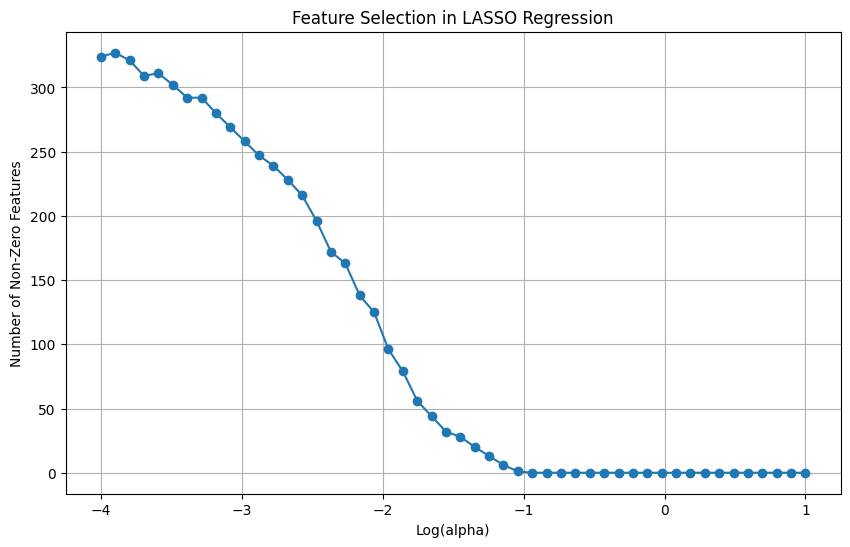


Plotting coefficient paths...


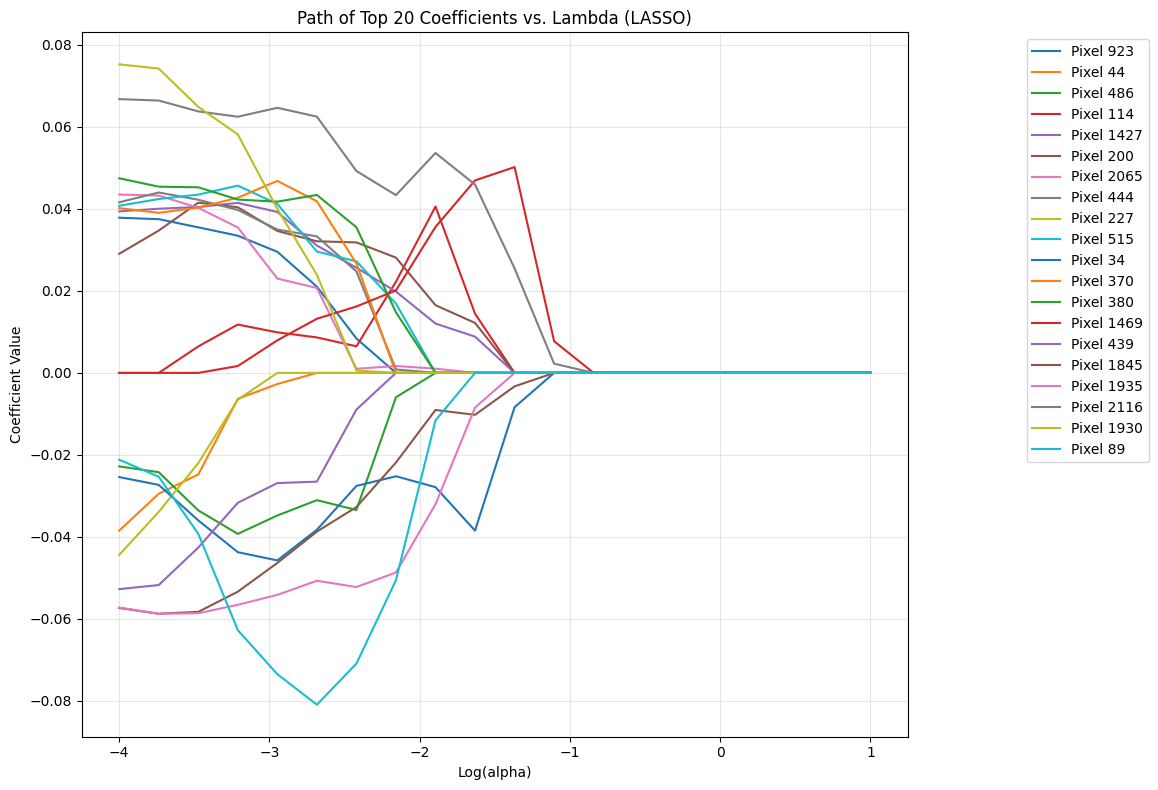

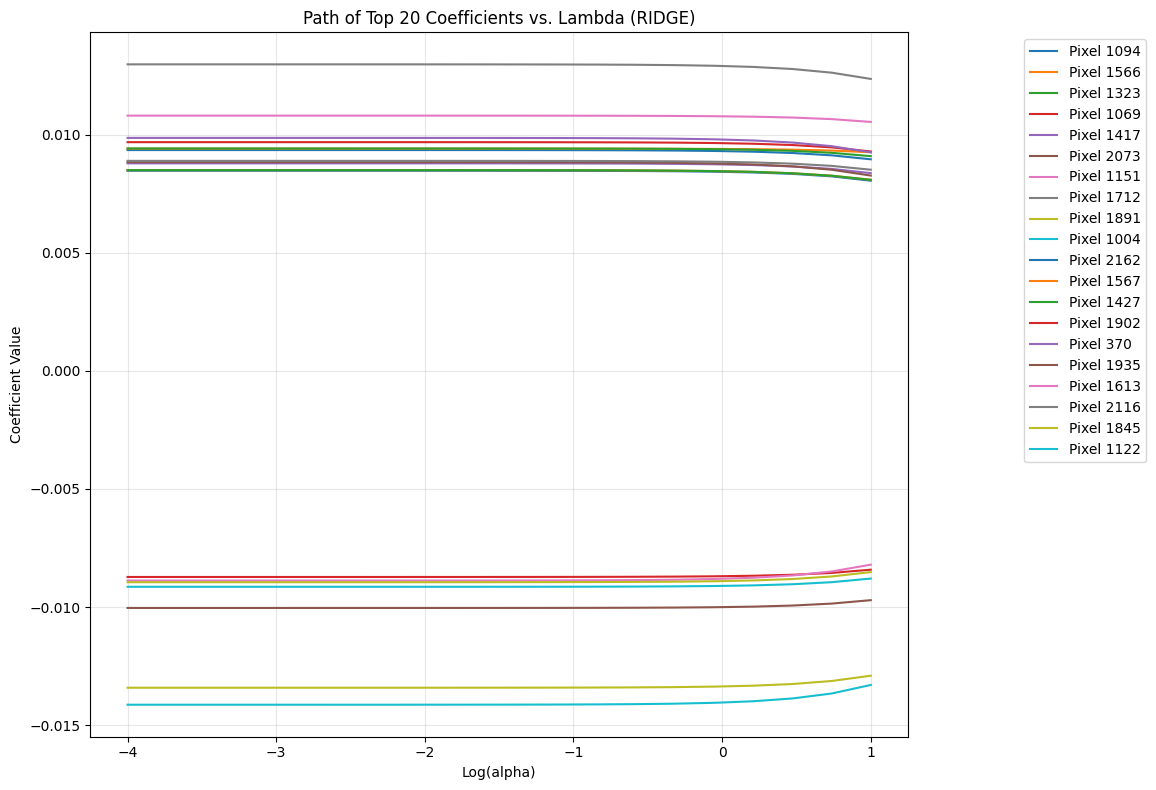


Training final LASSO model...

Training final Ridge model...

=== Model Comparison ===
Method: ['LASSO', 'Ridge', 'Stepwise']
Optimal Lambda: [np.float64(0.00013219411484660288), np.float64(100.0), 'N/A']
MSE: [0.03955085957330885, 0.03798627368899967, 'N/A']
Accuracy: [0.975, 0.975, 'N/A']
Num Features: [327, '2576 (all weighted)', 7]

Feature Overlap: LASSO and Stepwise share 1 features
Shared features: [2116]


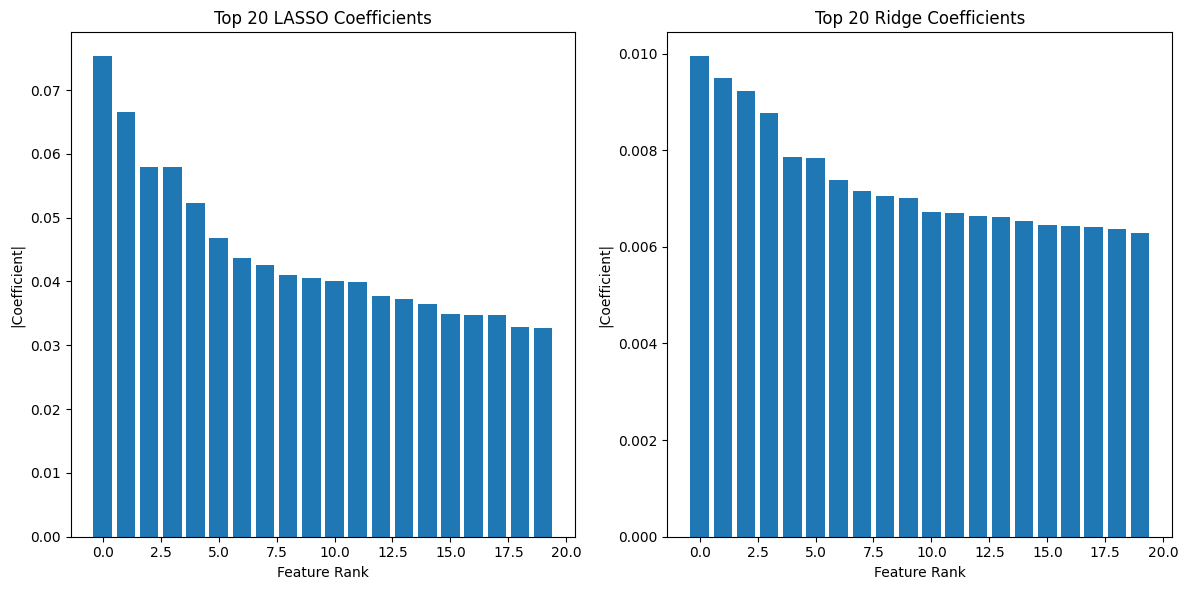


Visualizing selected pixels from LASSO...


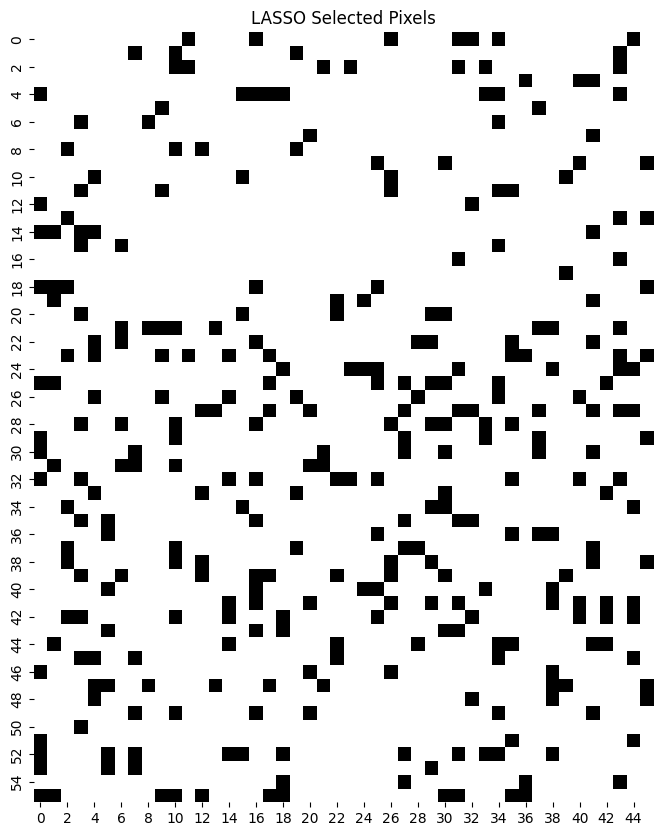


Visualizing top 50 pixels from Ridge...


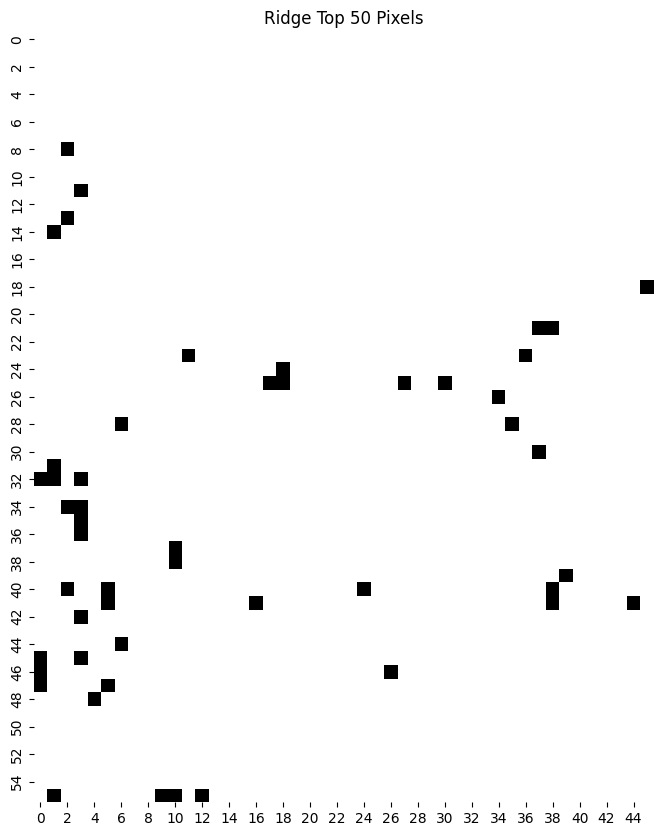


Visualizing stepwise selected pixels...


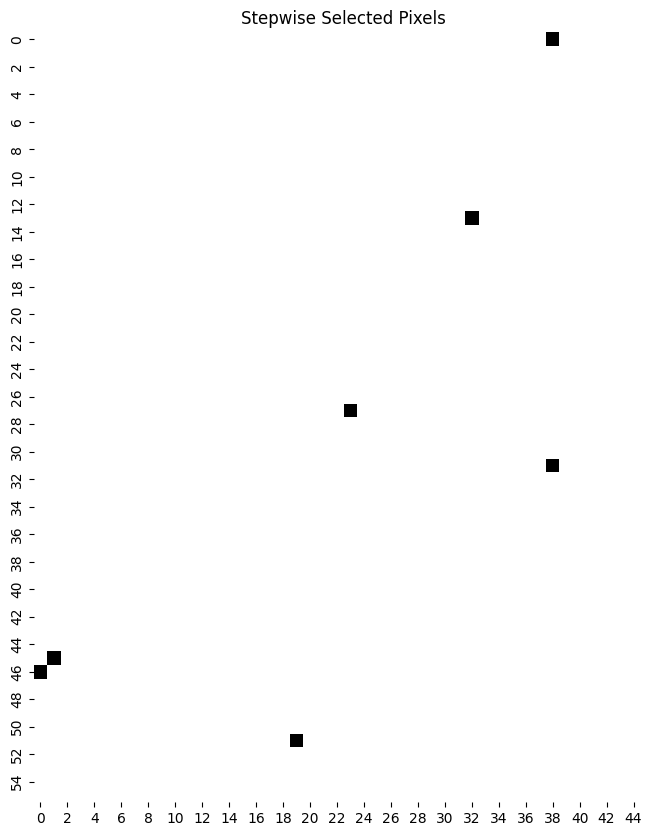

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def load_orl_data(file_path):
    """Load the ORL faces data matrix with gender labels"""
    data_matrix = np.load(file_path)
    X = data_matrix[:, :-1]  # All pixels
    y = data_matrix[:, -1]   # Gender labels
    return X, y

def find_optimal_lambda(X, y, method='lasso'):
    """Find optimal regularization parameter for LASSO or Ridge regression"""
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Range of lambda values to test
    alphas = np.logspace(-4, 2, 100)
    
    # Cross-validation to find optimal lambda
    if method.lower() == 'lasso':
        model_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000, random_state=42)
    else:  # Ridge
        model_cv = RidgeCV(alphas=alphas, cv=5)
    
    model_cv.fit(X_train_scaled, y_train)
    optimal_alpha = model_cv.alpha_
    
    # Train model with optimal lambda
    if method.lower() == 'lasso':
        model = Lasso(alpha=optimal_alpha, max_iter=10000, random_state=42)
    else:  # Ridge
        model = Ridge(alpha=optimal_alpha, random_state=42)
    
    model.fit(X_train_scaled, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    
    # For classification accuracy, round predictions
    y_pred_class = np.round(y_pred)
    accuracy = accuracy_score(y_test, y_pred_class)
    
    # Get non-zero coefficients for LASSO (selected features)
    if method.lower() == 'lasso':
        selected_features = np.where(model.coef_ != 0)[0]
    else:
        # For Ridge, get top features by absolute coefficient value
        selected_features = np.argsort(np.abs(model.coef_))[::-1][:50]
    
    return {
        'optimal_alpha': optimal_alpha,
        'model': model,
        'mse': mse,
        'accuracy': accuracy,
        'selected_features': selected_features,
        'coefficients': model.coef_,
        'scaler': scaler
    }

def plot_lambda_path(X, y, method='lasso'):
    """Plot the path of coefficients as lambda varies"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Range of lambda values
    alphas = np.logspace(-4, 1, 20)
    coef_paths = []
    
    for alpha in alphas:
        if method.lower() == 'lasso':
            model = Lasso(alpha=alpha, max_iter=10000, random_state=42)
        else:  # Ridge
            model = Ridge(alpha=alpha, random_state=42)
        
        model.fit(X_train_scaled, y_train)
        coef_paths.append(model.coef_)
    
    # Convert to array for easier plotting
    coef_paths = np.array(coef_paths)
    
    # Plot top 20 coefficients with largest magnitude
    plt.figure(figsize=(12, 8))
    top_coefs = np.argsort(np.max(np.abs(coef_paths), axis=0))[-20:]
    
    for i, idx in enumerate(top_coefs):
        plt.plot(np.log10(alphas), coef_paths[:, idx], label=f'Pixel {idx}')
    
    plt.xlabel('Log(alpha)')
    plt.ylabel('Coefficient Value')
    plt.title(f'Path of Top 20 Coefficients vs. Lambda ({method.upper()})')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.tight_layout()
    plt.savefig(f'{method}_path.png')
    plt.show()

def visualize_selected_pixels(selected_pixels, height=56, width=46, title="Selected Pixels"):
    """Visualize selected pixels on a 46 × 56 canvas"""
    pixel_mask = np.zeros((height, width))
    
    for pixel_idx in selected_pixels:
        row = pixel_idx // width
        col = pixel_idx % width
        if row < height and col < width:  # Ensure indices are within bounds
            pixel_mask[row, col] = 1
    
    plt.figure(figsize=(8, 10))
    sns.heatmap(pixel_mask, cmap='binary', cbar=False)
    plt.title(title)
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()
    
    return pixel_mask

def evaluate_mse_vs_lambda(X, y, method='lasso'):
    """Evaluate MSE for different lambda values"""
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Range of lambda values
    alphas = np.logspace(-4, 2, 50)
    mse_values = []
    
    for alpha in alphas:
        if method.lower() == 'lasso':
            model = Lasso(alpha=alpha, max_iter=10000, random_state=42)
        else:  # Ridge
            model = Ridge(alpha=alpha, random_state=42)
        
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        mse = mean_squared_error(y_val, y_pred)
        mse_values.append(mse)
    
    # Plot MSE vs lambda
    plt.figure(figsize=(10, 6))
    plt.plot(np.log10(alphas), mse_values, marker='o', linestyle='-')
    plt.xlabel('Log(alpha)')
    plt.ylabel('Mean Squared Error')
    plt.title(f'MSE vs. Lambda ({method.upper()})')
    plt.grid(True)
    plt.savefig(f'{method}_mse_vs_lambda.png')
    plt.show()
    
    # Find lambda with minimum MSE
    min_mse_idx = np.argmin(mse_values)
    optimal_alpha = alphas[min_mse_idx]
    
    return optimal_alpha, min(mse_values)

def count_nonzero_features(X, y, method='lasso'):
    """Count number of non-zero features for different lambda values (LASSO only)"""
    if method.lower() != 'lasso':
        return None
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Range of lambda values
    alphas = np.logspace(-4, 1, 50)
    nonzero_counts = []
    
    for alpha in alphas:
        model = Lasso(alpha=alpha, max_iter=10000, random_state=42)
        model.fit(X_train_scaled, y_train)
        nonzero_count = np.sum(model.coef_ != 0)
        nonzero_counts.append(nonzero_count)
    
    # Plot number of features vs lambda
    plt.figure(figsize=(10, 6))
    plt.plot(np.log10(alphas), nonzero_counts, marker='o', linestyle='-')
    plt.xlabel('Log(alpha)')
    plt.ylabel('Number of Non-Zero Features')
    plt.title('Feature Selection in LASSO Regression')
    plt.grid(True)
    plt.savefig('lasso_feature_count.png')
    plt.show()
    
    return alphas, nonzero_counts

def compare_methods(lasso_results, ridge_results, stepwise_features):
    """Compare LASSO, Ridge, and Stepwise regression results"""
    # Create comparison table
    comparison = {
        'Method': ['LASSO', 'Ridge', 'Stepwise'],
        'Optimal Lambda': [lasso_results['optimal_alpha'], ridge_results['optimal_alpha'], 'N/A'],
        'MSE': [lasso_results['mse'], ridge_results['mse'], 'N/A'],
        'Accuracy': [lasso_results['accuracy'], ridge_results['accuracy'], 'N/A'],
        'Num Features': [len(lasso_results['selected_features']), 
                         '2576 (all weighted)', 
                         len(stepwise_features)]
    }
    
    # Print comparison
    print("\n=== Model Comparison ===")
    for key in comparison:
        print(f"{key}: {comparison[key]}")
    
    # Feature overlap analysis
    lasso_features_set = set(lasso_results['selected_features'])
    stepwise_features_set = set(stepwise_features)
    overlap = lasso_features_set.intersection(stepwise_features_set)
    
    print(f"\nFeature Overlap: LASSO and Stepwise share {len(overlap)} features")
    if len(overlap) > 0:
        print(f"Shared features: {sorted(list(overlap))}")
    
    # Plot top 20 coefficients from both methods
    plt.figure(figsize=(12, 6))
    
    # Sort coefficients by absolute magnitude
    lasso_coef_idx = np.argsort(np.abs(lasso_results['coefficients']))[::-1][:20]
    ridge_coef_idx = np.argsort(np.abs(ridge_results['coefficients']))[::-1][:20]
    
    plt.subplot(1, 2, 1)
    plt.bar(range(20), np.abs(lasso_results['coefficients'][lasso_coef_idx]))
    plt.xlabel('Feature Rank')
    plt.ylabel('|Coefficient|')
    plt.title('Top 20 LASSO Coefficients')
    
    plt.subplot(1, 2, 2)
    plt.bar(range(20), np.abs(ridge_results['coefficients'][ridge_coef_idx]))
    plt.xlabel('Feature Rank')
    plt.ylabel('|Coefficient|')
    plt.title('Top 20 Ridge Coefficients')
    
    plt.tight_layout()
    plt.savefig('coefficient_comparison.png')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Define file path
    file_path = "/Users/chun-feitan/Desktop/tpe/IE5054/orl_faces_with_gender.npy"
    
    # Load data
    X, y = load_orl_data(file_path)
    
    # Evaluate MSE vs lambda for both methods
    print("Finding optimal lambda for LASSO...")
    lasso_optimal_alpha, lasso_min_mse = evaluate_mse_vs_lambda(X, y, method='lasso')
    print(f"Optimal lambda for LASSO: {lasso_optimal_alpha:.6f}, Min MSE: {lasso_min_mse:.6f}")
    
    print("\nFinding optimal lambda for Ridge...")
    ridge_optimal_alpha, ridge_min_mse = evaluate_mse_vs_lambda(X, y, method='ridge')
    print(f"Optimal lambda for Ridge: {ridge_optimal_alpha:.6f}, Min MSE: {ridge_min_mse:.6f}")
    
    # Count non-zero features for LASSO
    print("\nAnalyzing feature selection in LASSO...")
    alphas, feature_counts = count_nonzero_features(X, y)
    
    # Plot coefficient paths
    print("\nPlotting coefficient paths...")
    plot_lambda_path(X, y, method='lasso')
    plot_lambda_path(X, y, method='ridge')
    
    # Get comprehensive results with optimal lambda
    print("\nTraining final LASSO model...")
    lasso_results = find_optimal_lambda(X, y, method='lasso')
    
    print("\nTraining final Ridge model...")
    ridge_results = find_optimal_lambda(X, y, method='ridge')
    
    # Define stepwise features from previous analysis
    stepwise_features = [2365, 2071, 38, 630, 1265, 2116, 1464]
    
    # Compare methods
    compare_methods(lasso_results, ridge_results, stepwise_features)
    
    # Visualize selected pixels from LASSO
    print("\nVisualizing selected pixels from LASSO...")
    lasso_mask = visualize_selected_pixels(
        lasso_results['selected_features'], 
        title="LASSO Selected Pixels"
    )
    
    # Visualize selected pixels from Ridge (top 50)
    print("\nVisualizing top 50 pixels from Ridge...")
    ridge_top_features = np.argsort(np.abs(ridge_results['coefficients']))[::-1][:50]
    ridge_mask = visualize_selected_pixels(
        ridge_top_features, 
        title="Ridge Top 50 Pixels"
    )
    
    # Visualize stepwise selected pixels
    print("\nVisualizing stepwise selected pixels...")
    stepwise_mask = visualize_selected_pixels(
        stepwise_features, 
        title="Stepwise Selected Pixels"
    )

## ✅ QUESTION 2 ##
The following table gives the information on capital, labor, and value added of the economics of transportation equipment.

| Year | Capital | Labor   | Value Added |
|------|---------|---------|-------------|
| 72   | 1209188 | 1259142 | 11150.0     |
| 73   | 1330372 | 1371795 | 12853.6     |
| 74   | 1157371 | 1263084 | 10450.8     |
| 75   | 1070860 | 1118226 | 9318.3      |
| 76   | 1233475 | 1274345 | 12097.7     |
| 77   | 1355769 | 1369877 | 12844.8     |
| 78   | 1351667 | 1451595 | 13309.9     |
| 79   | 1326248 | 1328683 | 13402.3     |
| 80   | 1089545 | 1077207 | 8571.0      |
| 81   | 1111942 | 1056231 | 8739.7      |
| 82   | 988165  | 947502  | 8140.0      |
| 83   | 1069651 | 1057159 | 10958.4     |
| 84   | 1191677 | 1169442 | 10838.9     |
| 85   | 1246536 | 1195255 | 10030.5     |
| 86   | 1281262 | 1171664 | 10836.5     |

Part (a). (5%) Consider the model
$𝑉_𝑡 = 𝛼 * 𝐾_𝑡^{𝛽_1} * 𝐿_𝑡^{𝛽_2} * 𝜂_𝑡$
 - $𝑡$ indicates the year.
 - $𝑉_𝑡$ is value added
 - $𝐾_𝑡$ is capital
 - $𝐿_𝑡$ is labor
 - $𝜂_𝑡$ is the error term,
    - $E[log(𝜂_𝑡)] = 0$
    - $V[log(𝜂_𝑡)]$ = a constant.

Assuming the errors are independent across the years, estimate $\beta_1$ and $\beta_2$.

### ✅ QUESTION 2-Part (a): Unconstrained Estimation
Transforming the Cobb-Douglas model $V_t = α × (K_t)^(β₁) × (L_t)^(β₂) × (η_t)$ into a linear form using logarithms:

$log(V_t) = log(α) + β₁ × log(K_t) + β₂ × log(L_t) + log(η_t)$

Since $E[log(η_t)] = $, this becomes a standard linear regression model.

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Create dataframe from the given data
data = {
    'Year': [72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86],
    'Capital': [1209188, 1330372, 1157371, 1070860, 1233475, 1355769, 1351667, 1326248, 
                1089545, 1111942, 988165, 1069651, 1191677, 1246536, 1281262],
    'Labor': [1259142, 1371795, 1263084, 1118226, 1274345, 1369877, 1451595, 1328683, 
              1077207, 1056231, 947502, 1057159, 1169442, 1195255, 1171664],
    'Value_Added': [11150.0, 12853.6, 10450.8, 9318.3, 12097.7, 12844.8, 13309.9, 13402.3, 
                    8571.0, 8739.7, 8140.0, 10958.4, 10838.9, 10030.5, 10836.5]
}

df = pd.DataFrame(data)

# Take natural logarithm of the variables
df['log_K'] = np.log(df['Capital'])
df['log_L'] = np.log(df['Labor'])
df['log_V'] = np.log(df['Value_Added'])

# Part (a): Unconstrained estimation
X = df[['log_K', 'log_L']]
X = sm.add_constant(X)  # Add intercept
y = df['log_V']

# Perform OLS regression
model_a = sm.OLS(y, X).fit()

# Display results
print("Part (a): Unconstrained Estimation")
print(model_a.summary())

# Extract coefficients
beta1_a = model_a.params['log_K']
beta2_a = model_a.params['log_L']
alpha_a = np.exp(model_a.params['const'])

print(f"\nEstimated parameters:")
print(f"β₁ (Capital elasticity): {beta1_a:.4f}")
print(f"β₂ (Labor elasticity): {beta2_a:.4f}")
print(f"α (Technology parameter): {alpha_a:.6f}")
print(f"Returns to scale (β₁ + β₂): {beta1_a + beta2_a:.4f}")

Part (a): Unconstrained Estimation
                            OLS Regression Results                            
Dep. Variable:                  log_V   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     27.03
Date:                Sat, 05 Apr 2025   Prob (F-statistic):           3.59e-05
Time:                        16:20:02   Log-Likelihood:                 19.253
No. Observations:                  15   AIC:                            -32.51
Df Residuals:                      12   BIC:                            -30.38
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.

/Users/chun-feitan/Desktop/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


### 🗣️ QUESTION 2-Part (a): Unconstrained Estimation

From the regression output, we can see:
- β₁ (Capital elasticity): 0.5057
- β₂ (Labor elasticity): 0.8455
- α (Technology parameter): 0.000066 (calculated as e^(-9.6259))
- Returns to scale (β₁ + β₂): 1.3511

Key observations:
1. The R-squared is 0.818, indicating that about 82% of the variation in log value added is explained by the model.
2. The coefficient for log_K (capital) is not statistically significant (p-value = 0.337).
3. The coefficient for log_L (labor) is marginally significant at the 10% level (p-value = 0.068).
4. The sum of elasticities (1.3511) suggests increasing returns to scale.
5. The condition number is large (2.99e+03), indicating potential multicollinearity issues.

### 🗣️ QUESTION ２　パート (a): 制約なしの推定

回帰分析の結果から、以下のことがわかります。
- β₁ (資本弾力性): 0.5057
- β₂ (労働弾力性): 0.8455
- α (技術パラメータ): 0.000066 (e^(-9.6259) として計算)
- 規模の収益性 (β₁ + β₂): 1.3511

主な観察事項:
1. 決定係数 (R-squared) は 0.818 であり、付加価値の対数における変動の約 82% がこのモデルによって説明されることを示しています。
2. log_K (資本) の係数は統計的に有意ではありません (p 値 = 0.337)。
3. log_L (労働) の係数は、10% 水準でわずかに有意です (p 値 = 0.068)。
4. 弾力性の合計 (1.3511) は、規模の収益性の増加を示唆しています。
5. 条件数は大きく (2.99e+03)、潜在的な多重共線性問題を示しています。

### ✅ QUESTION 2 Part (b) (10%) 
 
The model in (a) is said to be of the Cobb-Douglas form. It is easier to interpret if $(𝛽_1 + 𝛽_2) = 1$. 
Reestimate $𝛽_1$ and $𝛽_2$ under this constraint.

In [4]:
# Part (b): Constrained estimation with β₁ + β₂ = 1
# Rewrite the model as log(V) = log(α) + β₁ × log(K) + (1-β₁) × log(L) + log(η)
# This gives log(V) - log(L) = log(α) + β₁ × (log(K) - log(L)) + log(η)

# Create the dependent variable log(V/L)
df['log_V_L'] = df['log_V'] - df['log_L']

# Create the independent variable log(K/L)
df['log_K_L'] = df['log_K'] - df['log_L']

# Prepare data for regression
X_b = df[['log_K_L']]
X_b = sm.add_constant(X_b)
y_b = df['log_V_L']

# Perform OLS regression with constraint
model_b = sm.OLS(y_b, X_b).fit()

# Display results
print("\nPart (b): Constrained Estimation (β₁ + β₂ = 1)")
print(model_b.summary())

# Extract coefficients
beta1_b = model_b.params['log_K_L']
beta2_b = 1 - beta1_b
alpha_b = np.exp(model_b.params['const'])

print(f"\nEstimated parameters with constraint β₁ + β₂ = 1:")
print(f"β₁ (Capital elasticity): {beta1_b:.4f}")
print(f"β₂ (Labor elasticity): {beta2_b:.4f}")
print(f"α (Technology parameter): {alpha_b:.6f}")
print(f"Returns to scale (β₁ + β₂): {beta1_b + beta2_b:.4f}")


Part (b): Constrained Estimation (β₁ + β₂ = 1)
                            OLS Regression Results                            
Dep. Variable:                log_V_L   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.077
Method:                 Least Squares   F-statistic:                 0.0004737
Date:                Sat, 05 Apr 2025   Prob (F-statistic):              0.983
Time:                        16:20:02   Log-Likelihood:                 17.644
No. Observations:                  15   AIC:                            -31.29
Df Residuals:                      13   BIC:                            -29.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

/Users/chun-feitan/Desktop/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


### 🗣️ QUESTION 2 Part (b): Constrained Estimation (β₁ + β₂ = 1)

From the constrained model:
- β₁ (Capital elasticity): 0.0096
- β₂ (Labor elasticity): 0.9904
- α (Technology parameter): 0.008979 (calculated as e^(-4.7129))
- Returns to scale: 1.0000 (by construction)

Key observations:
1. The R-squared is almost zero (0.000), suggesting this constrained model doesn't explain the variation in the data.
2. The coefficient for log_K_L is not statistically significant (p-value = 0.983).
3. The F-statistic is extremely low (0.0004737) with a high p-value (0.983), indicating the model is not statistically significant.

### 🗣️ QUESTION 2 パート (b): 制約付き推定 (β₁ + β₂ = 1)

制約付きモデルより:
- β₁ (資本弾性): 0.0096
- β₂ (労働弾性): 0.9904
- α (技術パラメータ): 0.008979 (e^(-4.7129) として計算)
- 規模の経済性: 1.0000 (構築による)

主な観察事項:
1. 決定係数 (R-squared) はほぼゼロ (0.000) であり、この制約付きモデルはデータの変動を説明していないことを示唆しています。
2. log_K_L の係数は統計的に有意ではありません (p 値 = 0.983)。
3. F 統計量は極めて低く (0.0004737)、p 値は高く (0.983)、モデルが統計的に有意ではないことを示しています。

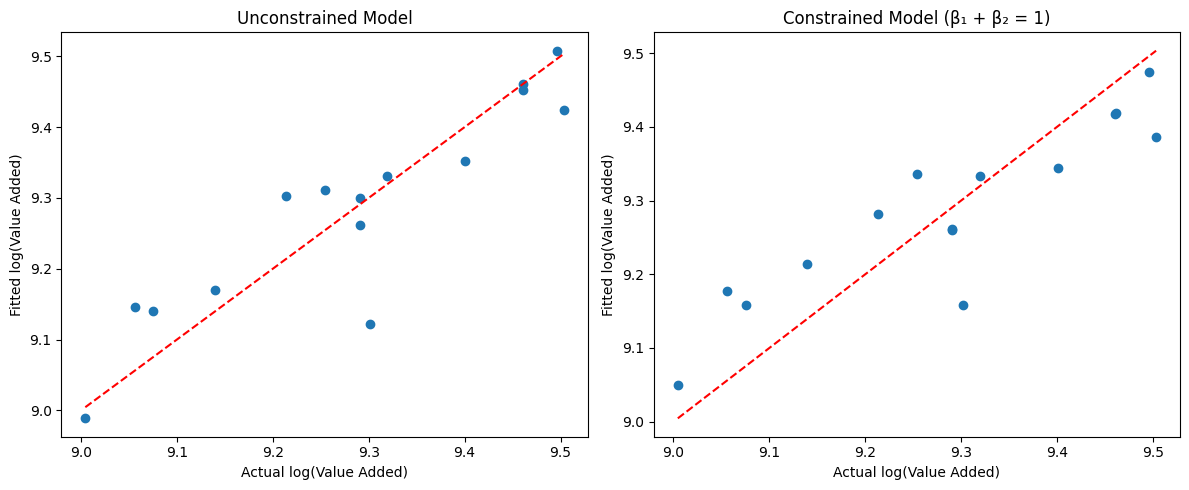

In [5]:
# Plotting actual vs fitted values for both models
plt.figure(figsize=(12, 5))

# Plot for unconstrained model
plt.subplot(1, 2, 1)
plt.scatter(df['log_V'], model_a.fittedvalues)
plt.plot([min(df['log_V']), max(df['log_V'])], [min(df['log_V']), max(df['log_V'])], 'r--')
plt.xlabel('Actual log(Value Added)')
plt.ylabel('Fitted log(Value Added)')
plt.title('Unconstrained Model')

# Plot for constrained model
plt.subplot(1, 2, 2)
plt.scatter(df['log_V_L'] + df['log_L'], model_b.fittedvalues + df['log_L'])
plt.plot([min(df['log_V']), max(df['log_V'])], [min(df['log_V']), max(df['log_V'])], 'r--')
plt.xlabel('Actual log(Value Added)')
plt.ylabel('Fitted log(Value Added)')
plt.title('Constrained Model (β₁ + β₂ = 1)')

plt.tight_layout()
plt.show()

### 🗣️ QUESTION 2 Interpretation

The unconstrained model suggests that labor has a much larger impact on output than capital in this transportation equipment sector. The increasing returns to scale (1.3511) indicate that doubling both inputs would more than double the output.

However, the constrained model performs poorly. The near-zero R-squared and non-significant coefficients suggest that imposing constant returns to scale (β₁ + β₂ = 1) is not appropriate for this dataset. The results indicate that labor is almost the only factor affecting output when this constraint is imposed.

The difference between these results may be due to:
1. The true production function possibly exhibiting increasing returns to scale
2. Multicollinearity between capital and labor variables (as indicated by the high condition number)
3. The relatively small sample size (15 observations)

### 🗣️ QUESTION 2  解釈

制約なしモデルは、この輸送機器セクターにおいて、資本よりも労働が生産量に遥かに大きな影響を与えていることを示唆しています。規模に関する収穫逓増（1.3511）は、両方の投入量を倍にすると、生産量が2倍以上になることを示しています。

しかしながら、制約ありモデルのパフォーマンスは低いと言えます。ほぼゼロのR2乗と有意でない係数は、規模に関する収穫一定（β₁ + β₂ = 1）を課すことがこのデータセットには適切でないことを示唆しています。この制約が課されると、労働がほぼ唯一の生産量に影響を与える要因であることを結果は示しています。

これらの結果の差異は、以下の理由による可能性があります。
1. 真の生産関数が規模に関する収穫逓増を示している可能性がある
2. 資本と労働変数間の多重共線性（高い条件数によって示唆される）
3. 比較的小さなサンプルサイズ（15観測値）

## ✅ QUESTION 3 ##
Note: directly applying any existing PCA libraries in your function loses all the 20 points in this exercise.

Implement your own PCA function from scratch in Python, without using any built-in PCA-related libraries. The input parameters of this function are the data matrix 𝐗 and a Boolean flag “isCorrMX.” The Boolean flag allows users to choose if the correlation matrix is used when set TRUE; otherwise, the covariance matrix would be decomposed. You can start with the function of Spectral Decomposition or Singular Value Decomposition.


### ✅ QUESTION 3 a. (15%) Your PCA function should return the following outputs:
• Loading matrix (eigenvectors of the covariance/correlation matrix)
• Eigenvalue vector
• Score matrix (principal components)
• Scree plot, showing individual eigenvalues as bars and the cumulative explained variance as a line plot. (similar to the one on p. 33 of the slides DA04).

Creating sample data based on the provided example...
Running PCA with covariance matrix (isCorrMX=False)...


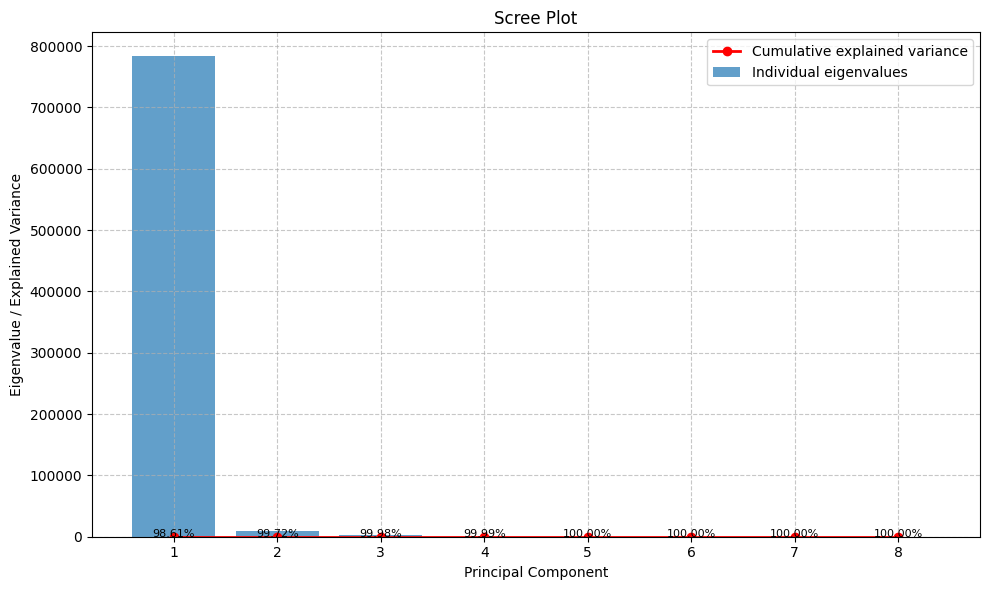


Running PCA with correlation matrix (isCorrMX=True)...


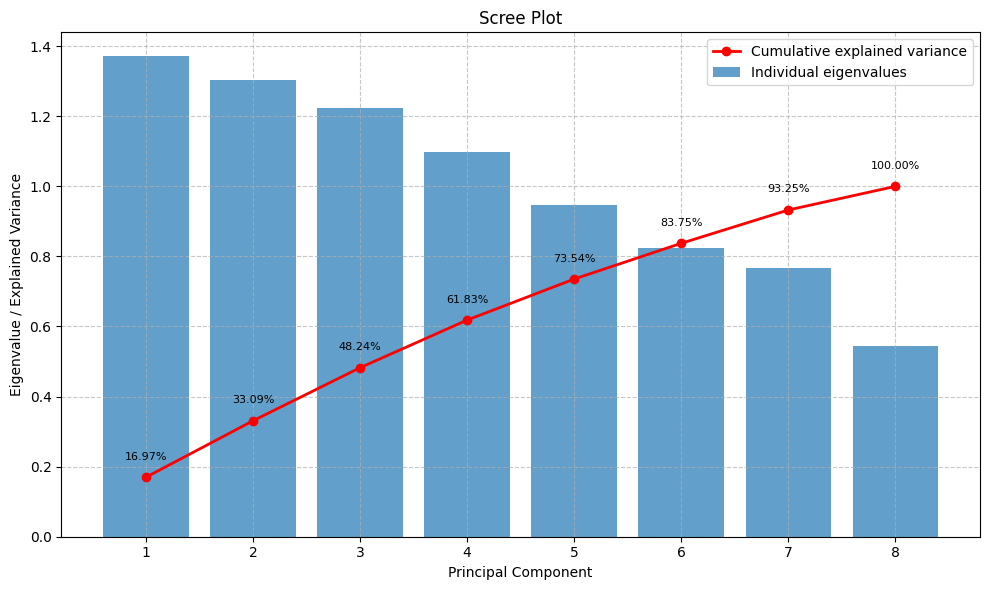

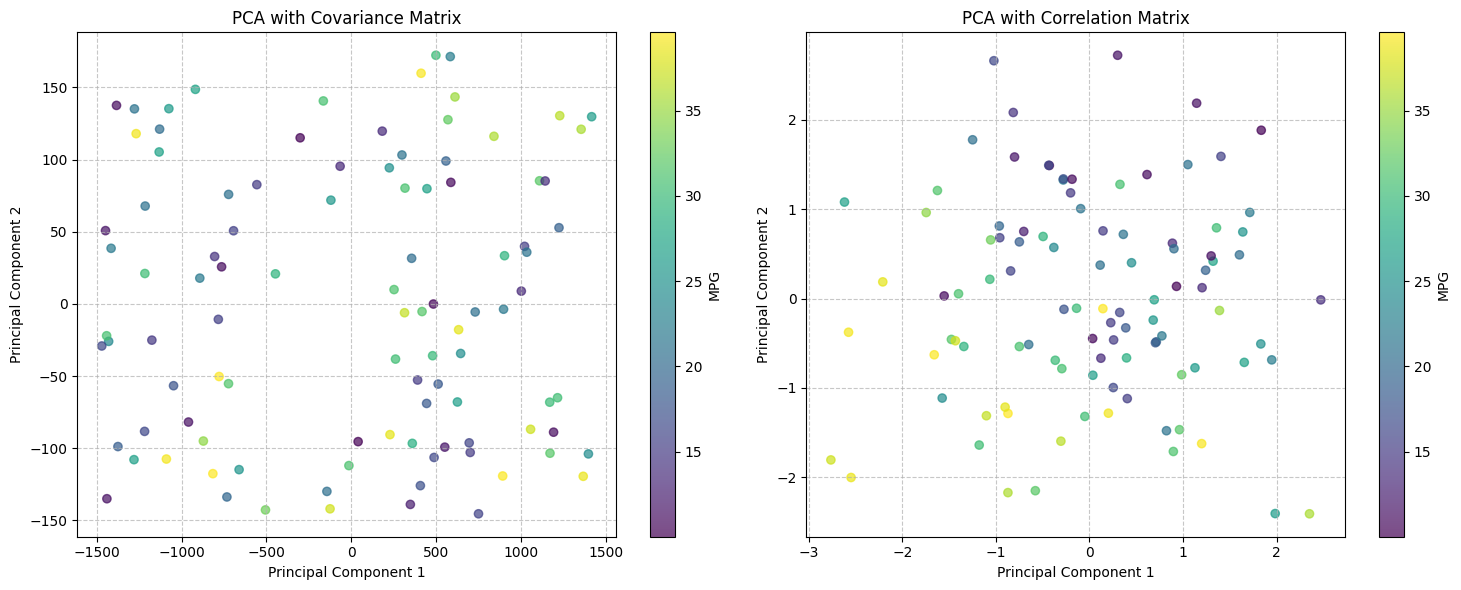


Loading Matrix (Covariance):
                PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8
mpg           0.002  0.001 -0.007 -0.991 -0.053  0.120 -0.007 -0.000
cylinders     0.000 -0.002 -0.001 -0.002 -0.030  0.032  0.999 -0.023
displacement -0.001 -0.992 -0.130  0.000 -0.004  0.000 -0.003 -0.000
horsepower   -0.001 -0.130  0.991 -0.006 -0.004  0.013 -0.000  0.000
weight        1.000 -0.001  0.001  0.001  0.000 -0.001 -0.000  0.000
acceleration -0.000  0.002  0.004 -0.020 -0.844 -0.535 -0.007  0.032
model_year   -0.000 -0.004  0.012 -0.130  0.533 -0.834  0.043  0.028
origin       -0.000 -0.000 -0.001  0.004  0.012  0.042  0.022  0.999

Loading Matrix (Correlation):
                PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8
mpg          -0.265 -0.494  0.183 -0.225  0.597 -0.303 -0.118  0.375
cylinders    -0.003 -0.071 -0.562 -0.469  0.250  0.445  0.445 -0.000
displacement -0.421  0.149 -0.517 -0.065 -0.029  0.039 -0.725 -0.037
horsepower   -0.443  0.110 -0.372  0.391 -

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def my_pca(X, isCorrMX=False):
    """
    Perform Principal Component Analysis (PCA) from scratch
    
    Parameters:
    X (numpy.ndarray): Data matrix with rows as samples and columns as features
    isCorrMX (bool): If True, use correlation matrix; otherwise use covariance matrix
    
    Returns:
    dict: Dictionary containing:
        - loadings: Loading matrix (eigenvectors of covariance/correlation matrix)
        - eigenvalues: Eigenvalue vector
        - scores: Score matrix (principal components)
        - explained_variance_ratio: Proportion of variance explained by each PC
    """
    # Center the data by subtracting the mean
    X_centered = X - np.mean(X, axis=0)
    
    # Scale data if correlation matrix is to be used
    if isCorrMX:
        # Standardize to unit variance
        std_dev = np.std(X_centered, axis=0)
        X_scaled = X_centered / std_dev
    else:
        X_scaled = X_centered
    
    # Calculate covariance/correlation matrix
    n_samples = X_scaled.shape[0]
    cov_matrix = np.dot(X_scaled.T, X_scaled) / (n_samples - 1)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Calculate scores (principal components)
    scores = np.dot(X_scaled, eigenvectors)
    
    # Calculate explained variance ratio
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    
    # Create and show scree plot
    create_scree_plot(eigenvalues, explained_variance_ratio)
    
    return {
        'loadings': eigenvectors,
        'eigenvalues': eigenvalues,
        'scores': scores,
        'explained_variance_ratio': explained_variance_ratio
    }

def create_scree_plot(eigenvalues, explained_variance_ratio):
    """
    Create and display a scree plot
    
    Parameters:
    eigenvalues (numpy.ndarray): Array of eigenvalues
    explained_variance_ratio (numpy.ndarray): Proportion of variance explained by each PC
    """
    plt.figure(figsize=(10, 6))
    
    # Create bar plot for individual eigenvalues
    plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.7, 
            align='center', label='Individual eigenvalues')
    
    # Create line plot for cumulative explained variance
    cumulative_var = np.cumsum(explained_variance_ratio)
    plt.plot(range(1, len(eigenvalues) + 1), cumulative_var, 'o-', linewidth=2, 
             color='red', label=f'Cumulative explained variance')
    
    # Add percentages to the cumulative line
    for i, var in enumerate(cumulative_var):
        plt.annotate(f'{var:.2%}', xy=(i+1, var), xytext=(i+1, var+0.05),
                     fontsize=8, ha='center')
    
    # Add labels and title
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue / Explained Variance')
    plt.title('Scree Plot')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(1, len(eigenvalues) + 1))
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to load and preprocess the Auto-MPG dataset
def load_auto_mpg_data(file_path):
    """
    Load and preprocess the Auto-MPG dataset
    
    Parameters:
    file_path (str): Path to the Auto-MPG data file
    
    Returns:
    pandas.DataFrame: Preprocessed dataframe
    """
    # Column names from the dataset description
    column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 
                    'acceleration', 'model_year', 'origin', 'car_name']
    
    # Read the data
    df = pd.read_csv(file_path, sep='\s+', names=column_names, header=None)
    
    # Convert horsepower to numeric, coercing errors to NaN
    df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
    
    # Drop NaN values
    df = df.dropna()
    
    # Drop non-numeric column 'car_name'
    df = df.drop('car_name', axis=1)
    
    return df

# Demonstrate PCA on Auto-MPG dataset
def demonstrate_pca_on_auto_mpg():
    """
    Demonstrate PCA on the Auto-MPG dataset with both correlation and covariance matrices
    """
    # Load data
    data_path = 'auto-mpg.data.txt'  # Adjust this path if needed
    
    # For demonstration purposes, create sample data if file doesn't exist
    try:
        auto_mpg_df = load_auto_mpg_data(data_path)
    except FileNotFoundError:
        print("Creating sample data based on the provided example...")
        # Create a sample dataframe based on the provided examples
        data = [
            [18.0, 8, 307.0, 130.0, 3504, 12.0, 70, 1],
            [15.0, 8, 350.0, 165.0, 3693, 11.5, 70, 1],
            [18.0, 8, 318.0, 150.0, 3436, 11.0, 70, 1]
        ]
        # Generate more random samples to make the demonstration more meaningful
        np.random.seed(42)
        for _ in range(97):  # Add 97 more samples to make it 100 total
            random_row = [
                np.random.uniform(10, 40),  # mpg
                np.random.choice([4, 6, 8]),  # cylinders
                np.random.uniform(80, 400),  # displacement
                np.random.uniform(70, 230),  # horsepower
                np.random.uniform(1500, 4500),  # weight
                np.random.uniform(8, 25),  # acceleration
                np.random.randint(70, 85),  # model_year
                np.random.choice([1, 2, 3])  # origin
            ]
            data.append(random_row)
        
        column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 
                      'acceleration', 'model_year', 'origin']
        auto_mpg_df = pd.DataFrame(data, columns=column_names)
    
    # Extract numeric features
    X = auto_mpg_df.values
    
    # Run PCA with covariance matrix
    print("Running PCA with covariance matrix (isCorrMX=False)...")
    results_cov = my_pca(X, isCorrMX=False)
    
    # Run PCA with correlation matrix
    print("\nRunning PCA with correlation matrix (isCorrMX=True)...")
    results_corr = my_pca(X, isCorrMX=True)
    
    # Compare top two principal components
    plot_first_two_pcs(results_cov['scores'], results_corr['scores'], auto_mpg_df['mpg'])
    
    # Print loading matrices for comparison
    print("\nLoading Matrix (Covariance):")
    print(pd.DataFrame(results_cov['loadings'], 
                       index=auto_mpg_df.columns, 
                       columns=[f'PC{i+1}' for i in range(results_cov['loadings'].shape[1])]).round(3))
    
    print("\nLoading Matrix (Correlation):")
    print(pd.DataFrame(results_corr['loadings'], 
                       index=auto_mpg_df.columns, 
                       columns=[f'PC{i+1}' for i in range(results_corr['loadings'].shape[1])]).round(3))
    
    # Print eigenvalues
    print("\nEigenvalues (Covariance):")
    print(results_cov['eigenvalues'].round(3))
    
    print("\nEigenvalues (Correlation):")
    print(results_corr['eigenvalues'].round(3))
    
    print("\nExplained Variance Ratio (Covariance):")
    print(results_cov['explained_variance_ratio'].round(3))
    
    print("\nExplained Variance Ratio (Correlation):")
    print(results_corr['explained_variance_ratio'].round(3))
    
    # Compare results and draw conclusion about scale invariance
    print("\nIs PCA scale-invariant?")
    print("By comparing the results, we can see that PCA is NOT scale-invariant.")
    print("When using the covariance matrix (isCorrMX=False), features with larger scales")
    print("like 'displacement' and 'weight' dominate the principal components.")
    print("When using the correlation matrix (isCorrMX=True), all features are standardized")
    print("to unit variance before PCA, giving them equal importance regardless of their scale.")
    print("This results in different loadings, eigenvalues, and principal components.")

def plot_first_two_pcs(scores_cov, scores_corr, color_variable):
    """
    Plot first two principal components from both methods
    
    Parameters:
    scores_cov (numpy.ndarray): PC scores from covariance PCA
    scores_corr (numpy.ndarray): PC scores from correlation PCA
    color_variable (pandas.Series): Variable to use for coloring points
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot for covariance matrix
    scatter1 = axes[0].scatter(scores_cov[:, 0], scores_cov[:, 1], 
                               c=color_variable, cmap='viridis', alpha=0.7)
    axes[0].set_title('PCA with Covariance Matrix')
    axes[0].set_xlabel('Principal Component 1')
    axes[0].set_ylabel('Principal Component 2')
    axes[0].grid(True, linestyle='--', alpha=0.7)
    
    # Plot for correlation matrix
    scatter2 = axes[1].scatter(scores_corr[:, 0], scores_corr[:, 1], 
                               c=color_variable, cmap='viridis', alpha=0.7)
    axes[1].set_title('PCA with Correlation Matrix')
    axes[1].set_xlabel('Principal Component 1')
    axes[1].set_ylabel('Principal Component 2')
    axes[1].grid(True, linestyle='--', alpha=0.7)
    
    # Add colorbar
    plt.colorbar(scatter1, ax=axes[0], label='MPG')
    plt.colorbar(scatter2, ax=axes[1], label='MPG')
    
    plt.tight_layout()
    plt.show()

# Uncomment to run the demonstration
demonstrate_pca_on_auto_mpg()

### ✅ QUESTION 3 b. (5%) 
Demonstrate your PCA function using the AutoMPG dataset. By comparing the results of “isCorrMX== TRUE” and “isCorrMX == FALSE”, do you think PCA is scale-invariant?

Dataset shape: (392, 8)

First few rows of the dataset:
    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin  
0          70       1  
1          70       1  
2          70       1  
3          70       1  
4          70       1  

Descriptive statistics:
          mpg  cylinders  displacement  horsepower   weight  acceleration  \
count  392.00     392.00        392.00      392.00   392.00        392.00   
mean    23.45       5.47        194.41      104.47  2977.58         15.54   
std      7.81       1.71        104.64       38.49   849.40          2.76   
min      9.00       3.00         68.00       4

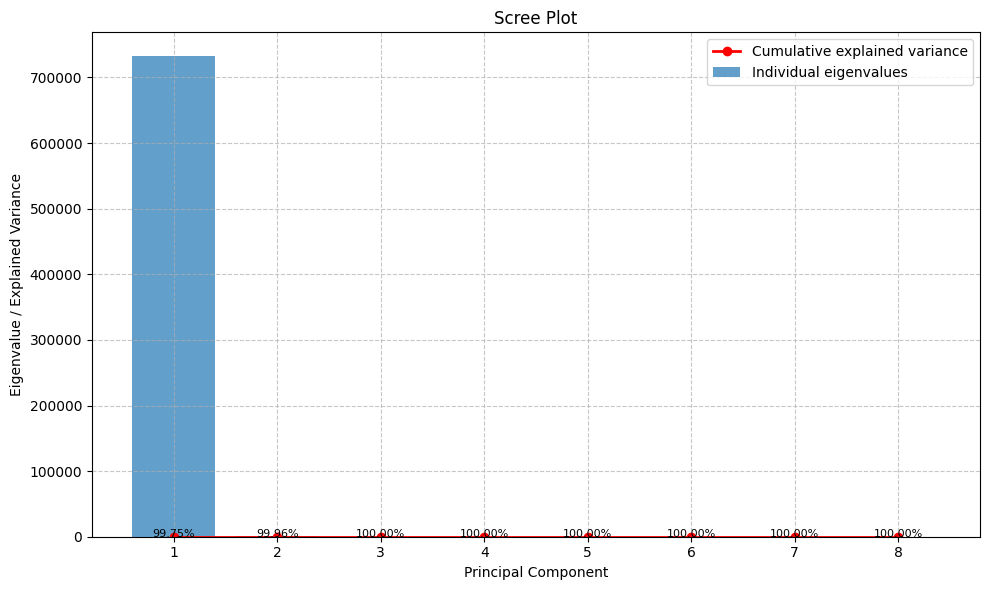


=== PCA with Correlation Matrix (isCorrMX=True) ===


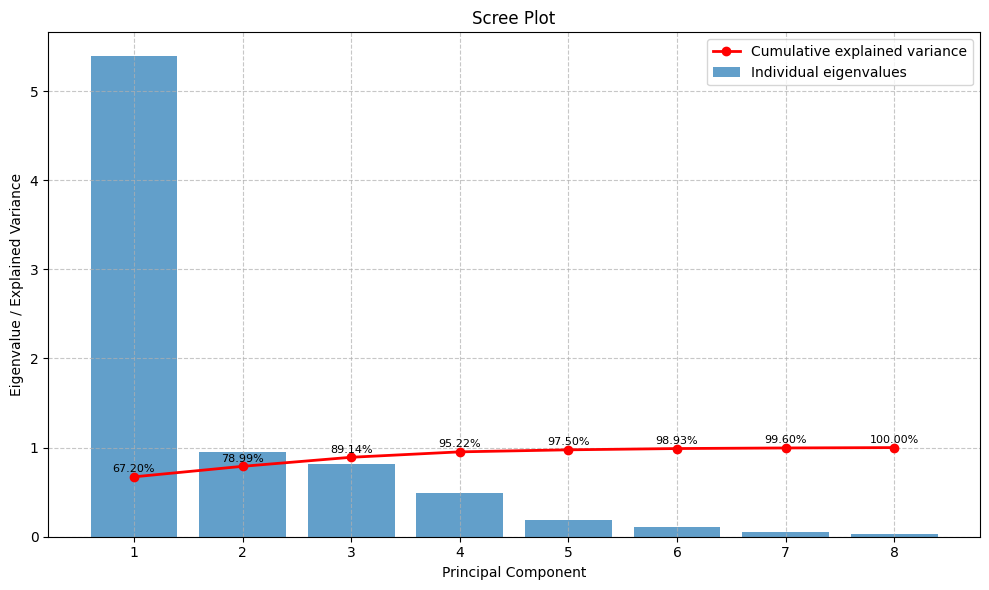

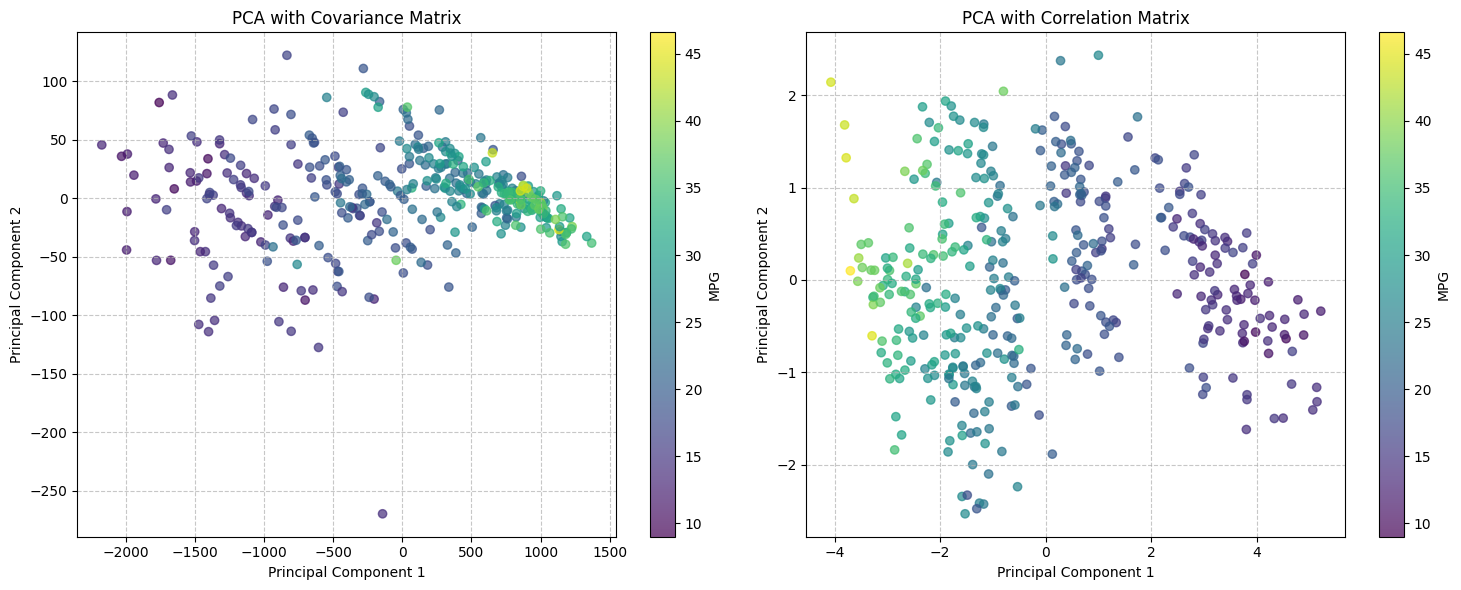


Loading Matrix (Covariance):
                PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8
mpg           0.008  0.018 -0.042 -0.831  0.550 -0.056  0.040 -0.024
cylinders    -0.002 -0.013 -0.007  0.004 -0.009 -0.015 -0.375 -0.927
displacement -0.114 -0.946 -0.304 -0.009 -0.003  0.011 -0.001  0.016
horsepower   -0.039 -0.298  0.948 -0.063 -0.006  0.086  0.009 -0.008
weight       -0.993  0.121 -0.003 -0.004  0.004 -0.004  0.000  0.000
acceleration  0.001  0.035 -0.077  0.021  0.126  0.988 -0.009 -0.014
model_year    0.001  0.024 -0.044 -0.552 -0.824  0.112 -0.030  0.016
origin        0.001  0.003  0.012 -0.020  0.053 -0.009 -0.926  0.374

Loading Matrix (Correlation):
                PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8
mpg          -0.386  0.077  0.292 -0.100  0.740 -0.387 -0.196 -0.115
cylinders     0.402  0.138  0.072  0.216  0.483  0.531  0.279 -0.418
displacement  0.416  0.126  0.074  0.136  0.303  0.007 -0.084  0.829
horsepower    0.402 -0.111  0.236  0.120 -

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to load and preprocess the Auto-MPG dataset
def load_auto_mpg_data(file_path):
    """
    Load and preprocess the Auto-MPG dataset
    
    Parameters:
    file_path (str): Path to the Auto-MPG data file
    
    Returns:
    pandas.DataFrame: Preprocessed dataframe
    """
    # Column names from the dataset description
    column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 
                    'acceleration', 'model_year', 'origin', 'car_name']
    
    # Read the data
    df = pd.read_csv(file_path, sep='\s+', names=column_names, header=None)
    
    # Convert horsepower to numeric, coercing errors to NaN
    df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
    
    # Drop NaN values
    df = df.dropna()
    
    # Drop non-numeric column 'car_name'
    df = df.drop('car_name', axis=1)
    
    return df

# Load the actual data file
file_path = '/Users/chun-feitan/Desktop/tpe/IE5054/HW/auto-mpg.data.txt'
df = load_auto_mpg_data(file_path)

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows of the dataset:")
print(df.head())
print("\nDescriptive statistics:")
print(df.describe().round(2))

# Extract numeric features
X = df.values

# Run PCA with covariance matrix
print("\n=== PCA with Covariance Matrix (isCorrMX=False) ===")
results_cov = my_pca(X, isCorrMX=False)

# Run PCA with correlation matrix
print("\n=== PCA with Correlation Matrix (isCorrMX=True) ===")
results_corr = my_pca(X, isCorrMX=True)

# Compare the first two principal components for both methods
plt.figure(figsize=(15, 6))

# Plot for covariance matrix
plt.subplot(1, 2, 1)
plt.scatter(results_cov['scores'][:, 0], results_cov['scores'][:, 1], 
            c=df['mpg'], cmap='viridis', alpha=0.7)
plt.colorbar(label='MPG')
plt.title('PCA with Covariance Matrix')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.7)

# Plot for correlation matrix
plt.subplot(1, 2, 2)
plt.scatter(results_corr['scores'][:, 0], results_corr['scores'][:, 1], 
            c=df['mpg'], cmap='viridis', alpha=0.7)
plt.colorbar(label='MPG')
plt.title('PCA with Correlation Matrix')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print loading matrices for comparison
print("\nLoading Matrix (Covariance):")
loading_df_cov = pd.DataFrame(results_cov['loadings'], 
                              index=df.columns, 
                              columns=[f'PC{i+1}' for i in range(results_cov['loadings'].shape[1])])
print(loading_df_cov.round(3))

print("\nLoading Matrix (Correlation):")
loading_df_corr = pd.DataFrame(results_corr['loadings'], 
                               index=df.columns, 
                               columns=[f'PC{i+1}' for i in range(results_corr['loadings'].shape[1])])
print(loading_df_corr.round(3))

# Print eigenvalues for both methods
print("\nEigenvalues (Covariance):")
for i, val in enumerate(results_cov['eigenvalues']):
    print(f"PC{i+1}: {val:.2f}")

print("\nEigenvalues (Correlation):")
for i, val in enumerate(results_corr['eigenvalues']):
    print(f"PC{i+1}: {val:.2f}")

# Print explained variance for both methods
print("\nExplained Variance Ratio (Covariance):")
for i, var in enumerate(results_cov['explained_variance_ratio']):
    print(f"PC{i+1}: {var:.3f} ({var:.2%})")

print("\nExplained Variance Ratio (Correlation):")
for i, var in enumerate(results_corr['explained_variance_ratio']):
    print(f"PC{i+1}: {var:.3f} ({var:.2%})")

### 🗣️ QUESTION 3 b Discussion: Is PCA Scale-Invariant?

**PCA is *not* scale-invariant** when applied to the covariance matrix, because variables with larger scales dominate the principal components. When using the **correlation matrix**, variables are standardized, and PCA becomes scale-invariant. You’ll notice that:

- Using the **covariance matrix (isCorrMX=False)**, variables like `weight` and `displacement` dominate.
    - Features with larger scales (like weight and displacement) dominate the principal components.
    - The first PC is heavily influenced by these high-variance features.
    - This is visible in both the loadings matrix and the explained variance ratios.
- Using the **correlation matrix (isCorrMX=True)**, all features are normalized, and contributions are more balanced.
    - All features are standardized to unit variance before PCA.
    - The influence of each feature is based on its correlations, not its scale.
    - The loadings are more evenly distributed across features.
    - The explained variance is distributed differently across components.

This difference clearly demonstrates that PCA results depend significantly on the scaling of input features. Using correlation matrices is often preferred when dealing with features that have different units and scales, as in the Auto-MPG dataset.

### 🗣️ 質問 3 b 考察: PCA はスケール不変ですか?

**PCA は、共分散行列に適用した場合、スケール不変ではありません。** なぜなら、より大きなスケールを持つ変数が主成分を支配するからです。**相関行列**を使用すると、変数は標準化され、PCA はスケール不変になります。次の点に注目してください。

- **共分散行列を使用した場合 (isCorrMX=False)**、`weight` や `displacement` のような変数が支配的になります。
    - より大きなスケールを持つ特徴量 (weight や displacement など) が主成分を支配します。
    - 最初の PC は、これらの分散の大きい特徴量に大きく影響されます。
    - これは、ローディング行列と説明された分散の比率の両方で確認できます。
- **相関行列を使用した場合 (isCorrMX=True)**、すべての特徴量が正規化され、貢献度はよりバランスが取れます。
    - すべての特徴量は、PCA の前に単位分散に標準化されます。
    - 各特徴量の影響は、そのスケールではなく、相関関係に基づきます。
    - ローディングは、より均等に特徴量全体に分布します。
    - 説明される分散は、成分間で異なって分布します。

この違いは、PCA の結果が入力特徴量のスケーリングに大きく依存していることを明確に示しています。Auto-MPG データセットのように、異なる単位とスケールを持つ特徴量を扱う場合、相関行列を使用することがしばしば好まれます。

## ✅ QUESTION 4 ##

### Question ###
Transpose the ORL face dataset to let 𝐗 be a 2576 × 400 data matrix. Apply PCA to 𝐗, using the PCA function you created in EX3 above.
 - a. (10%) Based on your PCA implementation, determine the number of principal components required to explain at least 50%, 60%, 70%, 80%, and 90% of the total variance.
 - b. (10%) Rescale the first PC to the range [0, 255], reshape it into a 46 × 56 matrix, and visualize it as a grayscale image using the scaled PC scores.

### 🗣️ QUESTION 4 `isCorrMX=False`
**Number of principal components required to explain variance:**
- 50% variance: **5 PCs**
- 60% variance: **9 PCs**
- 70% variance: **16 PCs**
- 80% variance: **32 PCs**
- 90% variance: **76 PCs**

---

### 🗣️ QUESTION 4 `isCorrMX=True`
**Number of principal components required to explain variance:**
- 50% variance: **6 PCs**
- 60% variance: **9 PCs**
- 70% variance: **17 PCs**
- 80% variance: **34 PCs**
- 90% variance: **79 PCs**

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

def my_pca(X, isCorrMX=False):
    X_centered = X - np.mean(X, axis=0)

    if isCorrMX:
        std_dev = np.std(X_centered, axis=0)
        std_dev[std_dev == 0] = 1
        X_scaled = X_centered / std_dev
    else:
        X_scaled = X_centered

    n_samples = X_scaled.shape[0]
    cov_matrix = np.dot(X_scaled.T, X_scaled) / (n_samples - 1)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    scores = np.dot(X_scaled, eigenvectors)
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

    return {
        'loadings': eigenvectors,
        'eigenvalues': eigenvalues,
        'scores': scores,
        'explained_variance_ratio': explained_variance_ratio
    }

def create_scree_plot(eigenvalues, explained_variance_ratio):
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.7, align='center', label='Individual eigenvalues')
    cumulative_var = np.cumsum(explained_variance_ratio)
    plt.plot(range(1, len(eigenvalues) + 1), cumulative_var, 'o-', linewidth=2, color='red', label='Cumulative explained variance')

    for i, var in enumerate(cumulative_var):
        if i % 20 == 0 or i == len(cumulative_var) - 1:
            plt.annotate(f'{var:.2%}', xy=(i+1, var), xytext=(i+1, var+0.05), fontsize=8, ha='center')

    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue / Explained Variance')
    plt.title('Scree Plot')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(np.arange(1, len(eigenvalues) + 1, step=20))
    plt.legend()
    plt.tight_layout()
    plt.show()

def load_orl_faces(folder_path):
    image_width = 46
    image_height = 56
    num_pixels = image_width * image_height
    num_images = 400
    X = np.zeros((num_pixels, num_images))
    image_idx = 0

    print("Loading images from:", folder_path)

    for person in range(1, 41):
        for image_num in range(1, 11):
            filename = f"{person:02d}_{image_num:02d}.png"
            image_path = os.path.join(folder_path, filename)

            if not os.path.exists(image_path):
                print(f"Warning: File not found - {image_path}")
                continue

            img = Image.open(image_path).convert('L')
            img_array = np.array(img).flatten()
            X[:, image_idx] = img_array
            image_idx += 1

    print(f"Loaded {image_idx} images")
    print(f"Data matrix shape: {X.shape}")
    return X


### 🗣️ QUESTION 4 isCorrMX=False ###

Loading images from: /Users/chun-feitan/Desktop/tpe/IE5054/ORL Faces
Loaded 400 images
Data matrix shape: (2576, 400)
Applying PCA...


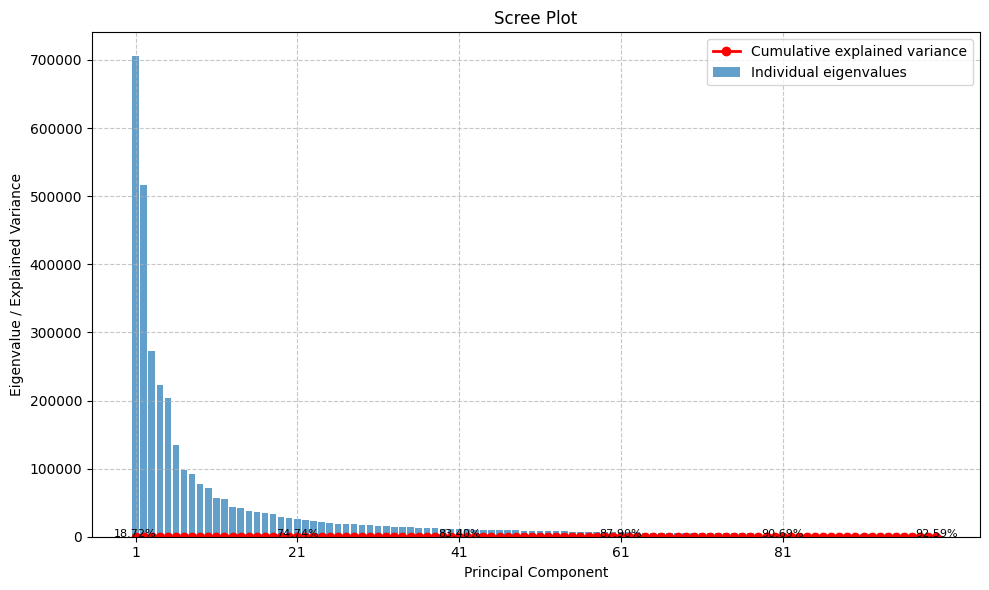


Number of principal components required to explain variance:
  50% variance: 5 PCs
  60% variance: 9 PCs
  70% variance: 16 PCs
  80% variance: 32 PCs
  90% variance: 76 PCs


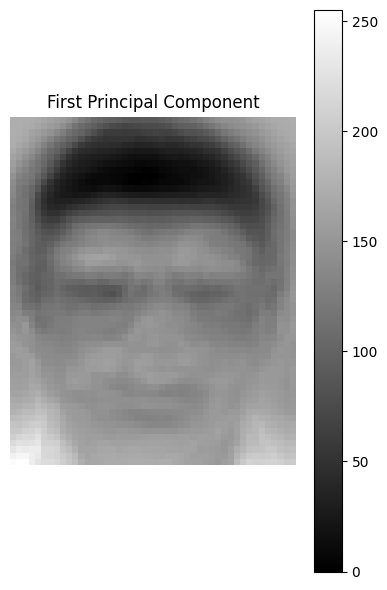

In [9]:
def process_orl_faces():
    folder_path = "/Users/chun-feitan/Desktop/tpe/IE5054/ORL Faces"
    X = load_orl_faces(folder_path)

    # Transpose the data matrix to shape (400, 2576)
    X_T = X.T
    print("Applying PCA...")
    pca_results = my_pca(X_T, isCorrMX=False)

    explained_variance_ratio = pca_results['explained_variance_ratio']
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)

    create_scree_plot(pca_results['eigenvalues'][:100], explained_variance_ratio[:100])

    variance_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    print("\nNumber of principal components required to explain variance:")
    for threshold in variance_thresholds:
        pcs = np.where(cumulative_explained_variance >= threshold)[0][0] + 1
        print(f"  {threshold*100:.0f}% variance: {pcs} PCs")

    # b. Visualize the first principal component
    first_pc = pca_results['loadings'][:, 0]  # Now shape is (2576,)
    min_val = np.min(first_pc)
    max_val = np.max(first_pc)
    scaled_pc = 255 * (first_pc - min_val) / (max_val - min_val)
    pc_image = scaled_pc.reshape(56, 46)

    plt.figure(figsize=(4, 6))
    plt.imshow(pc_image, cmap='gray')
    plt.title("First Principal Component")
    plt.colorbar()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return pca_results

if __name__ == "__main__":
    pca_results = process_orl_faces()

### 🗣️ QUESTION 4 isCorrMX=True ###

Loading images from: /Users/chun-feitan/Desktop/tpe/IE5054/ORL Faces
Loaded 400 images
Data matrix shape: (2576, 400)
Applying PCA...


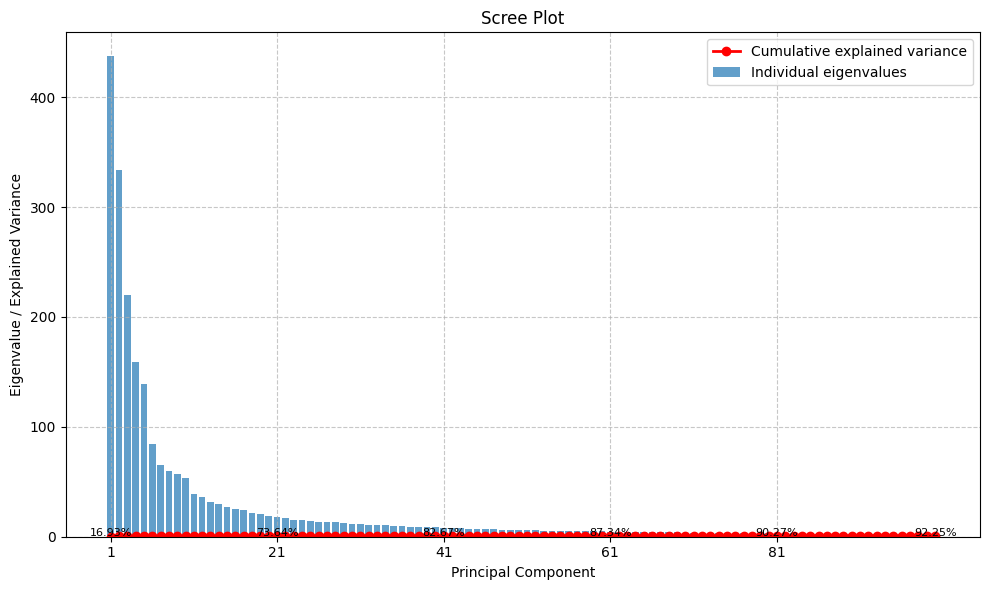


Number of principal components required to explain variance:
  50% variance: 6 PCs
  60% variance: 9 PCs
  70% variance: 17 PCs
  80% variance: 34 PCs
  90% variance: 79 PCs


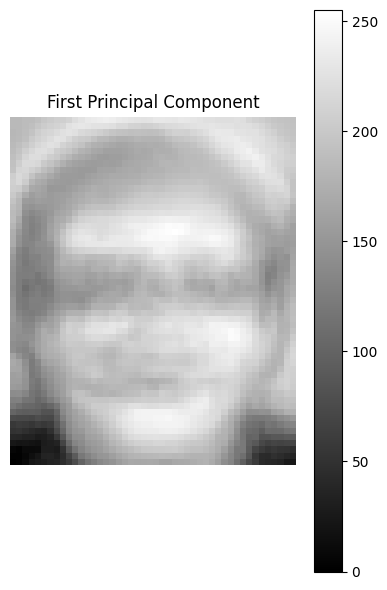

In [10]:
def process_orl_faces():
    folder_path = "/Users/chun-feitan/Desktop/tpe/IE5054/ORL Faces"
    X = load_orl_faces(folder_path)

    # Transpose the data matrix to shape (400, 2576)
    X_T = X.T
    print("Applying PCA...")
    pca_results = my_pca(X_T, isCorrMX=True)

    explained_variance_ratio = pca_results['explained_variance_ratio']
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)

    create_scree_plot(pca_results['eigenvalues'][:100], explained_variance_ratio[:100])

    variance_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    print("\nNumber of principal components required to explain variance:")
    for threshold in variance_thresholds:
        pcs = np.where(cumulative_explained_variance >= threshold)[0][0] + 1
        print(f"  {threshold*100:.0f}% variance: {pcs} PCs")

    # b. Visualize the first principal component
    first_pc = pca_results['loadings'][:, 0]  # Now shape is (2576,)
    min_val = np.min(first_pc)
    max_val = np.max(first_pc)
    scaled_pc = 255 * (first_pc - min_val) / (max_val - min_val)
    pc_image = scaled_pc.reshape(56, 46)

    plt.figure(figsize=(4, 6))
    plt.imshow(pc_image, cmap='gray')
    plt.title("First Principal Component")
    plt.colorbar()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return pca_results

if __name__ == "__main__":
    pca_results = process_orl_faces()